In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Importing and Preparing Dataset

In [3]:
dataset = pd.read_csv("/content/drive/MyDrive/Future Preparations/Data Science Training/Age, Gender and Ethnicity (face data)/dataset/age_gender.csv")
dataset.head()

,age,ethnicity,gender,img_name,pixels
0,1,2,0,20161219203650636.jpg.chip.jpg,129 128 128 126 127 130 133 135 139 142 145 14...
1,1,2,0,20161219222752047.jpg.chip.jpg,164 74 111 168 169 171 175 182 184 188 193 199...
2,1,2,0,20161219222832191.jpg.chip.jpg,67 70 71 70 69 67 70 79 90 103 116 132 145 155...
3,1,2,0,20161220144911423.jpg.chip.jpg,193 197 198 200 199 200 202 203 204 205 208 21...
4,1,2,0,20161220144914327.jpg.chip.jpg,202 205 209 210 209 209 210 211 212 214 218 21...


In [4]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23705 entries, 0 to 23704
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        23705 non-null  int64 
 1   ethnicity  23705 non-null  int64 
 2   gender     23705 non-null  int64 
 3   img_name   23705 non-null  object
 4   pixels     23705 non-null  object
dtypes: int64(3), object(2)
memory usage: 926.1+ KB


First of all the "pixel" column needs some processing so it can be used properly

In [5]:
## Converting pixels into numpy array
dataset['pixels'] = dataset['pixels'].apply(lambda x:  np.array(x.split(), dtype="float32"))
print(dataset.info())
dataset.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23705 entries, 0 to 23704
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        23705 non-null  int64 
 1   ethnicity  23705 non-null  int64 
 2   gender     23705 non-null  int64 
 3   img_name   23705 non-null  object
 4   pixels     23705 non-null  object
dtypes: int64(3), object(2)
memory usage: 926.1+ KB
None


,age,ethnicity,gender,img_name,pixels
0,1,2,0,20161219203650636.jpg.chip.jpg,"[129.0, 128.0, 128.0, 126.0, 127.0, 130.0, 133..."
1,1,2,0,20161219222752047.jpg.chip.jpg,"[164.0, 74.0, 111.0, 168.0, 169.0, 171.0, 175...."
2,1,2,0,20161219222832191.jpg.chip.jpg,"[67.0, 70.0, 71.0, 70.0, 69.0, 67.0, 70.0, 79...."
3,1,2,0,20161220144911423.jpg.chip.jpg,"[193.0, 197.0, 198.0, 200.0, 199.0, 200.0, 202..."
4,1,2,0,20161220144914327.jpg.chip.jpg,"[202.0, 205.0, 209.0, 210.0, 209.0, 209.0, 210..."


There is an issue with this dataset and that is the dataset is so big. In general this is not that big of an issue but for me, since I don't have that much computing power, I might need to trim the dataset a little bit.

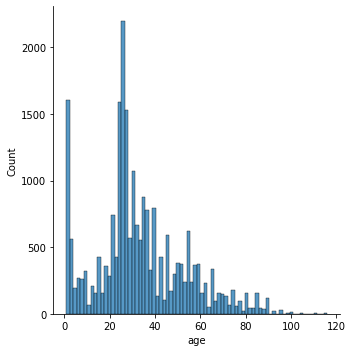

In [26]:
sns.displot(data=dataset, x="age")

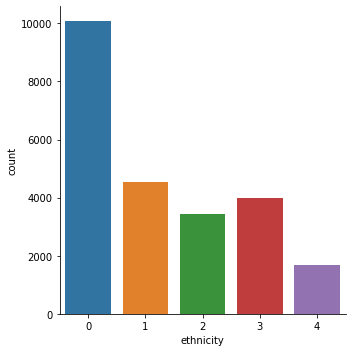

In [31]:
sns.catplot(data=dataset, x="ethnicity", kind="count")

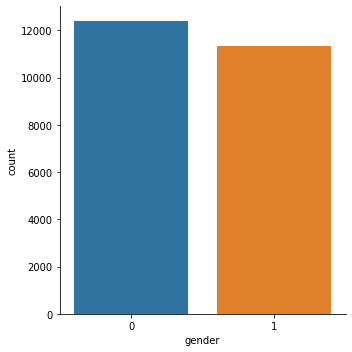

In [30]:
sns.catplot(data=dataset, x="gender", kind="count")

In [6]:
X = np.array(dataset["pixels"].tolist())/255.
X.shape

(23705, 2304)

In [7]:
X = X.reshape((X.shape[0], 48, 48, 1))

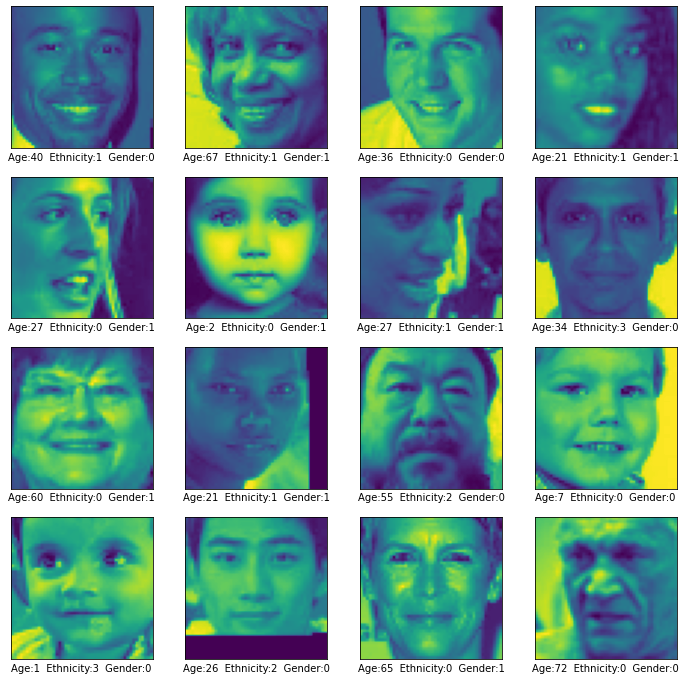

In [11]:
plt.figure(figsize=(12, 12))
randidx = np.random.randint(0, X.shape[0], (16))
for i in range(len(randidx)):
  plt.subplot(4, 4, i+1)
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  plt.imshow(X[randidx[i]].reshape(48,48))
  plt.xlabel(
      "Age:"+str(dataset['age'].iloc[randidx[i]])+
      "  Ethnicity:"+str(dataset['ethnicity'].iloc[randidx[i]])+
      "  Gender:"+ str(dataset['gender'].iloc[randidx[i]])
      )
plt.show()

Now that I know the size of the image data, I probably can do it with the whole dataset since the image size is quite small and only has one channel

In [66]:
Y = dataset.drop(["pixels", "img_name"], axis=1)
Y.head()

,age,ethnicity,gender
0,1,2,0
1,1,2,0
2,1,2,0
3,1,2,0
4,1,2,0


In [67]:
Y = Y.to_numpy()
Y.shape

(23705, 3)

# Model

for starters let's make three separate models for three different problems

In [68]:
Y_age = np.expand_dims(Y[..., 0], axis=-1)
Y_ethnic = np.expand_dims(Y[..., 1], axis=-1)
Y_gender = np.expand_dims(Y[..., 2], axis=-1)
print(Y_age.shape)
print(Y_ethnic.shape)
print(Y_gender.shape)

(23705, 1)
(23705, 1)
(23705, 1)


## Gender model

In [85]:
X_gen_train, X_gen_test, Y_gen_train, Y_gen_test = train_test_split(
    X, Y_gender, test_size=0.2, random_state=7)
print(X_gen_train.shape)
print(X_gen_test.shape)
print(Y_gen_train.shape)
print(Y_gen_test.shape)

(18964, 48, 48, 1)
(4741, 48, 48, 1)
(18964, 1)
(4741, 1)


In [80]:
def gender_model(size=None):
  x = inputs = tf.keras.layers.Input([size, size, 1])
  x = tf.keras.layers.Conv2D(32, 3, activation='relu')(x)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.MaxPooling2D(2)(x)
  x = tf.keras.layers.Conv2D(64, 3, activation='relu')(x)
  x = tf.keras.layers.MaxPooling2D(2)(x)
  x = tf.keras.layers.Flatten()(x)
  x = tf.keras.layers.Dense(64, activation='relu')(x)
  x = tf.keras.layers.Dropout(0.5)(x)
  outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)
  return tf.keras.Model(inputs, outputs)

In [95]:
genmod = gender_model(size=48)
genmod.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 48, 48, 1)]       0         
                                                                 
 conv2d_12 (Conv2D)          (None, 46, 46, 32)        320       
                                                                 
 batch_normalization_6 (Batc  (None, 46, 46, 32)       128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 23, 23, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 21, 21, 64)        18496     
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 10, 10, 64)       0   

In [96]:
genmod.compile(optimizer='adam',
               loss="binary_crossentropy",
               metrics=['accuracy'])

In [94]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

In [97]:
history = genmod.fit(X_gen_train, Y_gen_train,
                    epochs=20, batch_size=64, 
                    validation_split=0.1, callbacks=[callback],
                    verbose=1)

Epoch 1/20
267/267 [==============================] - 40s 149ms/step - loss: 0.4373 - accuracy: 0.7962 - val_loss: 0.5554 - val_accuracy: 0.8324
Epoch 2/20
267/267 [==============================] - 40s 148ms/step - loss: 0.3210 - accuracy: 0.8593 - val_loss: 0.4139 - val_accuracy: 0.7876
Epoch 3/20
267/267 [==============================] - 40s 148ms/step - loss: 0.2888 - accuracy: 0.8738 - val_loss: 0.2823 - val_accuracy: 0.8730
Epoch 4/20
267/267 [==============================] - 40s 148ms/step - loss: 0.2607 - accuracy: 0.8826 - val_loss: 0.2847 - val_accuracy: 0.8677
Epoch 5/20
267/267 [==============================] - 39s 148ms/step - loss: 0.2481 - accuracy: 0.8897 - val_loss: 0.2669 - val_accuracy: 0.8782
Epoch 6/20
267/267 [==============================] - 40s 148ms/step - loss: 0.2262 - accuracy: 0.9005 - val_loss: 0.2727 - val_accuracy: 0.8856
Epoch 7/20
267/267 [==============================] - 39s 148ms/step - loss: 0.2130 - accuracy: 0.9044 - val_loss: 0.2892 - val_ac

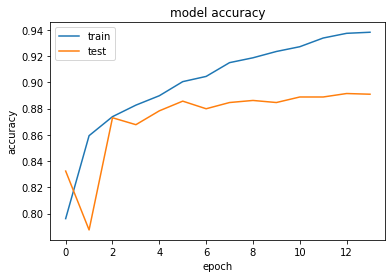

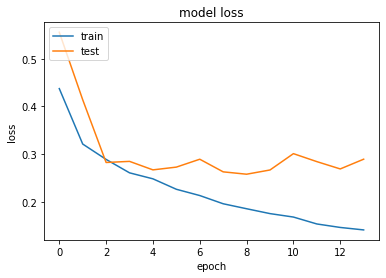

In [98]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [99]:
loss, acc = genmod.evaluate(X_gen_test, Y_gen_test, batch_size=128, verbose=0)
print(f"model loss = {loss}")
print(f"model accuracy = {acc}")

model loss = 0.278447687625885
model accuracy = 0.8995992541313171


In [130]:
genmod.save('gender_model.h5')

## Ethnic model

In [100]:
X_eth_train, X_eth_test, Y_eth_train, Y_eth_test = train_test_split(
    X, Y_ethnic, test_size=0.2, random_state=7)
print(X_eth_train.shape)
print(X_eth_test.shape)
print(Y_eth_train.shape)
print(Y_eth_test.shape)

(18964, 48, 48, 1)
(4741, 48, 48, 1)
(18964, 1)
(4741, 1)


In [232]:
def ethnic_model(classes, size=None):
  x = inputs = tf.keras.layers.Input([size, size, 1])
  x = tf.keras.layers.Conv2D(32, 3, activation='relu', padding='same')(x)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.MaxPooling2D(2)(x)
  x = tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same')(x)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.MaxPooling2D(2)(x)
  x = tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same')(x)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.MaxPooling2D(2)(x)
  #x = tf.keras.layers.Conv2D(64, 3, activation='relu')(x)
  #x = tf.keras.layers.MaxPooling2D(2)(x)
  x = tf.keras.layers.Flatten()(x)
  x = tf.keras.layers.Dense(128, activation='relu')(x)
  #x = tf.keras.layers.Dropout(0.6)(x)
  #x = tf.keras.layers.Dense(32, activation='relu')(x)
  x = tf.keras.layers.Dropout(0.6)(x)
  #x = tf.keras.layers.Dense(32, activation='relu')(x)
  #x = tf.keras.layers.Dropout(0.4)(x)

  if classes == 2:
    activation = 'sigmoid'
    units = 1
  else:
    activation = 'softmax'
    units = classes

  outputs = tf.keras.layers.Dense(units, activation=activation)(x)
  return tf.keras.Model(inputs, outputs)

In [233]:
ethnicmod = ethnic_model(5, 48)
ethnicmod.summary()

Model: "model_36"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_40 (InputLayer)       [(None, 48, 48, 1)]       0         
                                                                 
 conv2d_101 (Conv2D)         (None, 48, 48, 32)        320       
                                                                 
 batch_normalization_54 (Bat  (None, 48, 48, 32)       128       
 chNormalization)                                                
                                                                 
 max_pooling2d_95 (MaxPoolin  (None, 24, 24, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_102 (Conv2D)         (None, 24, 24, 64)        18496     
                                                                 
 batch_normalization_55 (Bat  (None, 24, 24, 64)       256

In [234]:
ethnicmod.compile(optimizer='adam',
                  loss="sparse_categorical_crossentropy",
                  metrics=['accuracy'])

In [216]:
callback2 = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5)

In [235]:
history2 = ethnicmod.fit(X_eth_train, Y_eth_train,
                        epochs=20, batch_size=64, 
                        validation_split=0.1, callbacks=[callback2],
                        verbose=1)

Epoch 1/20
267/267 [==============================] - 62s 229ms/step - loss: 1.3248 - accuracy: 0.5120 - val_loss: 2.4892 - val_accuracy: 0.4280
Epoch 2/20
267/267 [==============================] - 63s 237ms/step - loss: 0.9922 - accuracy: 0.6421 - val_loss: 0.9161 - val_accuracy: 0.7022
Epoch 3/20
267/267 [==============================] - 62s 231ms/step - loss: 0.9039 - accuracy: 0.6744 - val_loss: 0.7815 - val_accuracy: 0.7127
Epoch 4/20
267/267 [==============================] - 63s 234ms/step - loss: 0.8403 - accuracy: 0.6999 - val_loss: 0.8254 - val_accuracy: 0.6758
Epoch 5/20
267/267 [==============================] - 61s 229ms/step - loss: 0.7975 - accuracy: 0.7218 - val_loss: 0.8906 - val_accuracy: 0.6985
Epoch 6/20
267/267 [==============================] - 60s 225ms/step - loss: 0.7349 - accuracy: 0.7469 - val_loss: 0.8277 - val_accuracy: 0.7085
Epoch 7/20
267/267 [==============================] - 61s 229ms/step - loss: 0.7058 - accuracy: 0.7546 - val_loss: 0.7280 - val_ac

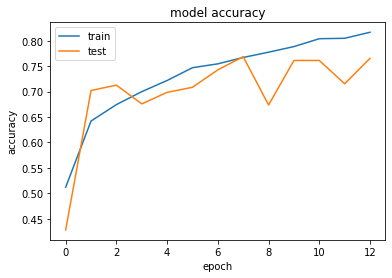

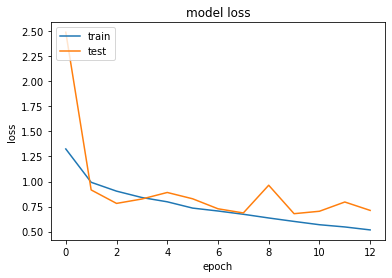

In [237]:
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [238]:
loss2, acc2 = ethnicmod.evaluate(X_eth_test, Y_eth_test, batch_size=128, verbose=0)
print(f"model loss = {loss2}")
print(f"model accuracy = {acc2}")

model loss = 0.7226574420928955
model accuracy = 0.7751529216766357


In [250]:
ethnicmod.save("ethnicity_model.h5")

## Age Model

In [239]:
X_age_train, X_age_test, Y_age_train, Y_age_test = train_test_split(
    X, Y_age, test_size=0.2, random_state=7)
print(X_age_train.shape)
print(X_age_test.shape)
print(Y_age_train.shape)
print(Y_age_test.shape)

(18964, 48, 48, 1)
(4741, 48, 48, 1)
(18964, 1)
(4741, 1)


In [242]:
def age_model(size=None):
  x = inputs = tf.keras.layers.Input([size, size, 1])
  x = tf.keras.layers.Conv2D(32, 3, activation='relu', padding='same')(x)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.Conv2D(32, 3, activation='relu', padding='same')(x)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.MaxPooling2D(2)(x)
  x = tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same')(x)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same')(x)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.MaxPooling2D(2)(x)
  x = tf.keras.layers.Conv2D(128, 3, activation='relu', padding='same')(x)
  x = tf.keras.layers.MaxPooling2D(2)(x)
  x = tf.keras.layers.Flatten()(x)
  x = tf.keras.layers.Dense(64, activation='relu')(x)
  #x = tf.keras.layers.Dropout(0.7)(x)
  #x = tf.keras.layers.Dense(32, activation='relu')(x)
  x = tf.keras.layers.Dropout(0.5)(x)
  outputs = tf.keras.layers.Dense(1)(x)
  return tf.keras.Model(inputs, outputs)

In [243]:
agemod = age_model(48)
agemod.summary()

Model: "model_38"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_42 (InputLayer)       [(None, 48, 48, 1)]       0         
                                                                 
 conv2d_107 (Conv2D)         (None, 48, 48, 32)        320       
                                                                 
 batch_normalization_59 (Bat  (None, 48, 48, 32)       128       
 chNormalization)                                                
                                                                 
 conv2d_108 (Conv2D)         (None, 48, 48, 32)        9248      
                                                                 
 batch_normalization_60 (Bat  (None, 48, 48, 32)       128       
 chNormalization)                                                
                                                                 
 max_pooling2d_101 (MaxPooli  (None, 24, 24, 32)       0  

I mistakenly put accuracy as one of the metrics but I only relized it once the training was already on more than 5 epochs and I didn't want to restart the training, so please just ignore it

In [248]:
agemod.compile(optimizer='adam',
               loss="mse",
               metrics=['accuracy', 'mae'])

In [246]:
callback3 = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

In [249]:
history3 = agemod.fit(X_age_train, Y_age_train,
                      epochs=20, batch_size=64, 
                      validation_split=0.1, callbacks=[callback3],
                      verbose=1)

Epoch 1/20
267/267 [==============================] - 168s 628ms/step - loss: 245.9604 - accuracy: 0.0445 - mae: 11.7539 - val_loss: 396.5988 - val_accuracy: 0.0532 - val_mae: 14.5333
Epoch 2/20
267/267 [==============================] - 170s 637ms/step - loss: 161.3043 - accuracy: 0.0307 - mae: 9.4289 - val_loss: 211.3133 - val_accuracy: 0.0485 - val_mae: 10.5047
Epoch 3/20
267/267 [==============================] - 170s 637ms/step - loss: 141.1106 - accuracy: 0.0314 - mae: 8.7500 - val_loss: 131.0464 - val_accuracy: 0.0395 - val_mae: 8.2461
Epoch 4/20
267/267 [==============================] - 170s 636ms/step - loss: 131.5661 - accuracy: 0.0323 - mae: 8.4491 - val_loss: 136.4941 - val_accuracy: 0.0532 - val_mae: 8.5074
Epoch 5/20
267/267 [==============================] - 170s 635ms/step - loss: 126.5572 - accuracy: 0.0362 - mae: 8.2241 - val_loss: 98.9363 - val_accuracy: 0.0532 - val_mae: 7.5146
Epoch 6/20
267/267 [==============================] - 170s 637ms/step - loss: 114.6874 -

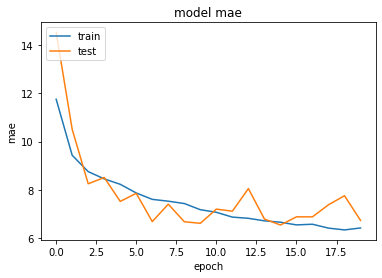

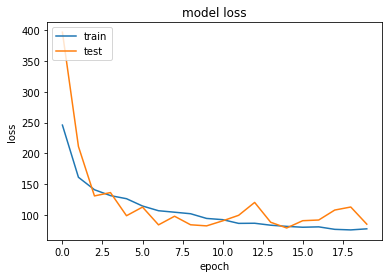

In [252]:
plt.plot(history3.history['mae'])
plt.plot(history3.history['val_mae'])
plt.title('model mae')
plt.ylabel('mae')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history3.history['loss'])
plt.plot(history3.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [256]:
mse,__, mae = agemod.evaluate(X_age_test, Y_age_test, batch_size=128, verbose=0)
print(f"mean squared error loss = {mse}")
print(f"mean absolute error accuracy = {mae}")

mean squared error loss = 87.08493041992188
mean absolute error accuracy = 6.87603235244751


In [257]:
agemod.save('age_model.h5')

# Testing

In [29]:
np.argmax(np.arange(12).reshape(3,4), axis=0)

array([2, 2, 2, 2])

In [12]:
gendertest = tf.keras.models.load_model('gender_model.h5')
ethnictest = tf.keras.models.load_model('ethnicity_model.h5')
agetest = tf.keras.models.load_model('age_model.h5')

In [32]:
def genderpred(X, model=gendertest):
  pred = model.predict(X)
  return np.round(pred).astype(int)

def ethnicpred(X, model=ethnictest):
  pred = model.predict(X)
  return np.argmax(pred, axis=1)

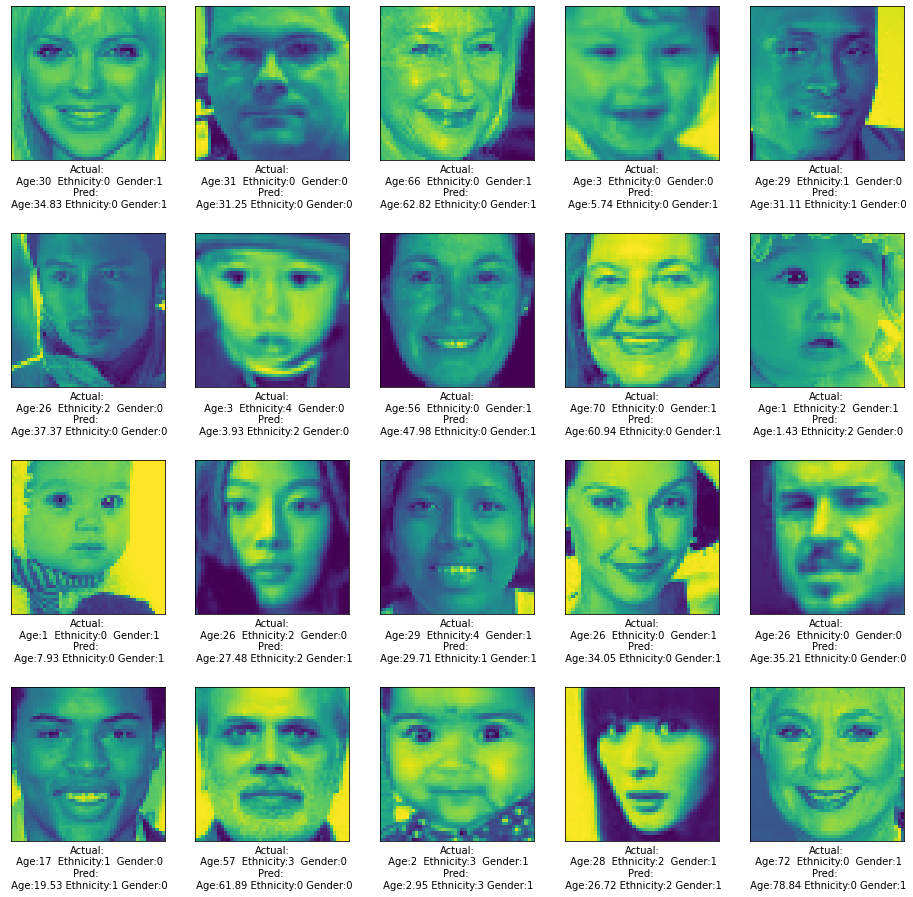

In [65]:
plt.figure(figsize=(16, 16))
randidx = np.random.randint(0, X.shape[0], (20))
picked_images = np.take(X, randidx, axis=0)

#predictions
genderpreds = genderpred(picked_images)
ethnicpreds = ethnicpred(picked_images)
agepreds = agetest.predict(picked_images)
agepreds = np.around(agepreds, decimals=2)

for i in range(len(randidx)):
  plt.subplot(4, 5, i+1)
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  plt.imshow(picked_images[i].reshape(48,48))
  plt.xlabel(
      "Actual:\n Age:"+str(dataset['age'].iloc[randidx[i]])+
      "  Ethnicity:"+str(dataset['ethnicity'].iloc[randidx[i]])+
      "  Gender:"+ str(dataset['gender'].iloc[randidx[i]])+
      "\nPred: \n " + "Age:" + str(np.squeeze(agepreds[i])) + 
      " Ethnicity:" + str(ethnicpreds[i]) + 
      " Gender:" + str(np.squeeze(genderpreds[i])))
plt.show()